# Assignment 3

In [2]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display

# Load and prepare the dataset

In [4]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 3s 0us/step


In [6]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

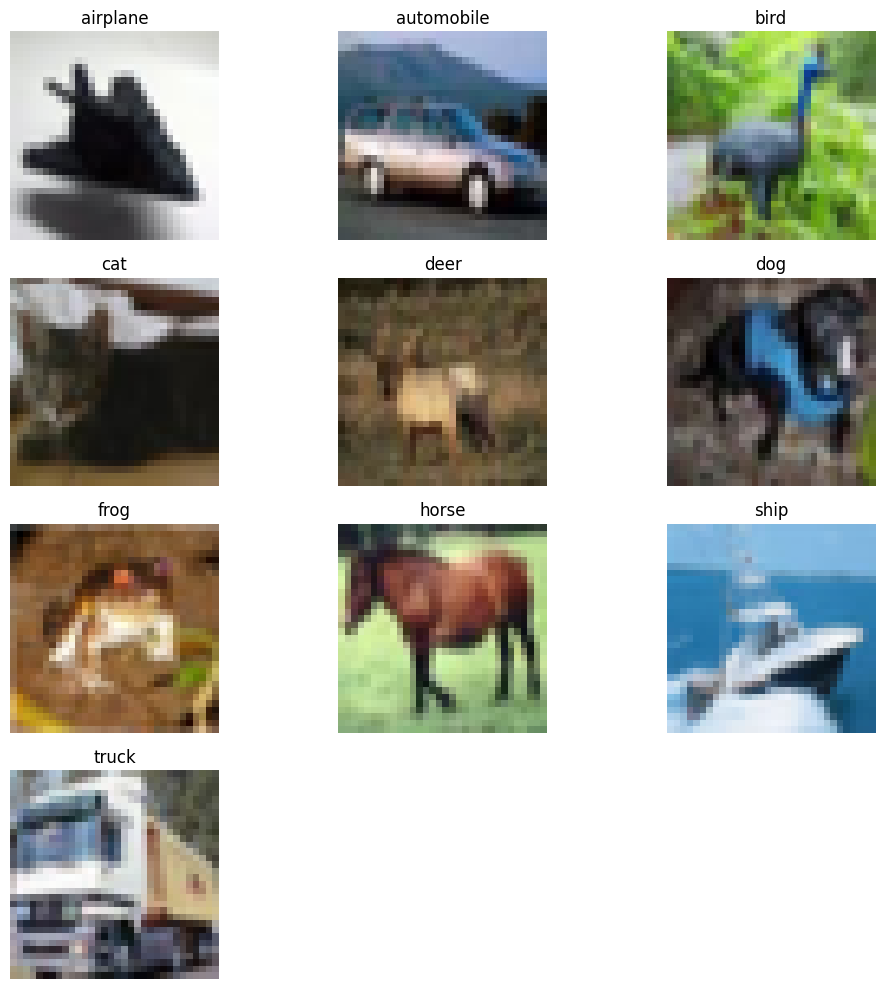

In [7]:
def display_images(images, labels, class_names):
    plt.figure(figsize=(10, 10))
    class_types = len(class_names)

    labels = labels.flatten()

    indices = []
    for j in range(len(class_names)):
        for i in range(len(labels)):
            if labels[i] == j:
                indices.append(i)
                break

    for i in range(class_types):
        ax = plt.subplot(4, 3, i + 1)
        plt.imshow(images[indices[i]])
        plt.title(class_names[labels[indices[i]]])
        plt.axis("off")

    plt.tight_layout()
    plt.show()

display_images(train_images, train_labels, class_names)

In [5]:
# Check shapes of the dataset
print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)

Train images shape: (50000, 32, 32, 3)
Train labels shape: (50000, 1)
Test images shape: (10000, 32, 32, 3)
Test labels shape: (10000, 1)


In [ ]:
train_images = train_images.astype(np.float32)
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [8]:
train_images.shape[0]

50000

In [ ]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

2024-04-16 20:26:21.096005: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 20:26:21.133498: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 20:26:21.137134: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

# Create the models

# The Generator

In [9]:
def make_generator_model():
    model = tf.keras.Sequential([
        # Project and reshape from the noise seed
        layers.Dense(4*4*1024, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((4, 4, 1024)),
        #assert model.output_shape == (None, 4, 4, 1024)  # Note: None is the batch size

        # Convolutional layers with upsampling
        layers.Conv2DTranspose(512, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        #assert model.output_shape == (None, 8, 8, 512),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        #assert model.output_shape == (None, 16, 16, 256),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        #assert model.output_shape == (None, 32, 32, 128),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    assert model.output_shape == (None, 64, 64, 3)
    return model

In [10]:
generator = make_generator_model()

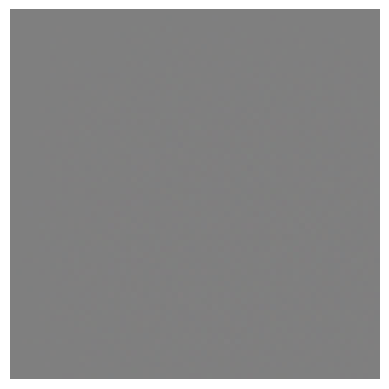

In [11]:
# Create the generator model
generator = make_generator_model()

# Generate random noise as input
noise = tf.random.normal([1, 100])  # 1 here represents one image, 100 is the dimension of the noise vector

# Generate an image from the noise
generated_image = generator(noise, training=False)

# Normalize the image from range [-1, 1] to [0, 1] for display purposes
normalized_image = (generated_image[0] + 1) / 2  # Adjust the first and only image in the batch

# Display the normalized image
plt.imshow(normalized_image)
plt.axis('off')  # Hide the axes
plt.show()

In [12]:
generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 16384)             1638400   
                                                                 
 batch_normalization_4 (Bat  (None, 16384)             65536     
 chNormalization)                                                
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16384)             0         
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 1024)        0         
                                                                 
 conv2d_transpose_4 (Conv2D  (None, 8, 8, 512)         13107200  
 Transpose)                                                      
                                                                 
 batch_normalization_5 (Bat  (None, 8, 8, 512)        

# The Discriminator

In [13]:
# Discriminator Model
def make_discriminator_model():
    model = tf.keras.Sequential([
        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', input_shape=[64, 64, 3]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Conv2D(1024, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

In [15]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-5.6229095e-05]], shape=(1, 1), dtype=float32)


In [16]:
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 128)       9728      
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 32, 32, 128)       0         
                                                                 
 dropout_4 (Dropout)         (None, 32, 32, 128)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 256)       819456    
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 16, 16, 256)       0         
                                                                 
 dropout_5 (Dropout)         (None, 16, 16, 256)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 8, 512)        

# Define the loss and optimizers

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Discriminator loss

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# Generator loss

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Define the training loop

In [ ]:
EPOCHS = 350
noise_dim = 100
num_examples_to_generate = 32
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      images = tf.image.resize(images, [64, 64])

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

# Generate and save images

In [ ]:
def calculate_diversity(images):
    # Flatten images and calculate the standard deviation across all pixels
    images_flat = images.reshape(images.shape[0], -1)
    pixel_std = np.std(images_flat, axis=0).mean()
    return pixel_std

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    predictions = (predictions + 1) / 2  # Normalize to [0, 1]

    diversity_score = calculate_diversity(predictions.numpy())  # Calculate diversity to check mode collapse
    print(f"Diversity score at epoch {epoch}: {diversity_score}\n")

    fig = plt.figure(figsize=(10, 10))
    num_images = min(predictions.shape[0], 32)
    for i in range(num_images):
        ax = plt.subplot(8, 4, i + 1)
        ax.imshow(predictions[i])
        ax.axis('off')

    plt.savefig(f'image_at_epoch_{epoch:04d}.png')
    plt.show()


In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    print(f"Epoch {epoch+1}/{epochs} completed.")

In [ ]:
train(train_dataset, EPOCHS)

Epoch 1/350 completed.
Epoch 2/350 completed.
Epoch 3/350 completed.
Epoch 4/350 completed.
Epoch 5/350 completed.
Epoch 6/350 completed.
Epoch 7/350 completed.
Epoch 8/350 completed.
Epoch 9/350 completed.
Epoch 10/350 completed.
Epoch 11/350 completed.
Epoch 12/350 completed.
Epoch 13/350 completed.
Epoch 14/350 completed.
Epoch 15/350 completed.
Epoch 16/350 completed.
Epoch 17/350 completed.
Epoch 18/350 completed.
Epoch 19/350 completed.
Epoch 20/350 completed.
Epoch 21/350 completed.
Epoch 22/350 completed.
Epoch 23/350 completed.
Epoch 24/350 completed.
Epoch 25/350 completed.
Epoch 26/350 completed.
Epoch 27/350 completed.
Epoch 28/350 completed.
Epoch 29/350 completed.
Epoch 30/350 completed.
Epoch 31/350 completed.
Epoch 32/350 completed.
Epoch 33/350 completed.
Epoch 34/350 completed.
Epoch 35/350 completed.
Epoch 36/350 completed.
Epoch 37/350 completed.
Epoch 38/350 completed.
Epoch 39/350 completed.
Epoch 40/350 completed.
Epoch 41/350 completed.
Epoch 42/350 completed.
E

As we can see

Diversity score at epoch 350: 0.2026023417711258



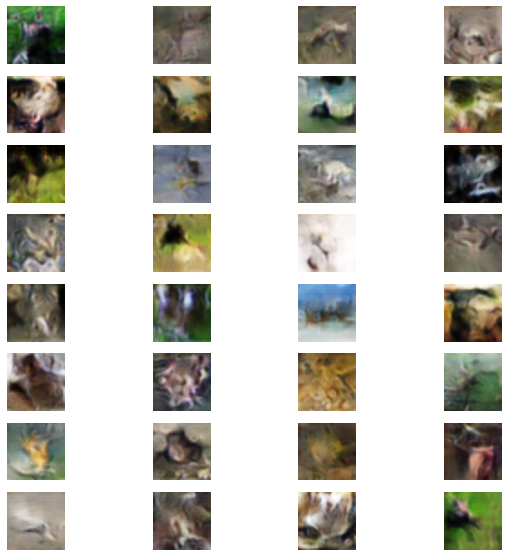

In [ ]:
generate_and_save_images(generator, 350, seed)

Mode collapse is a common issue in the training of Generative Adversarial Networks (GANs), where the generator model starts producing a limited variety of outputs, despite being given different input noise vectors.

From the above images we not able to see much. But we could say that all the images look different

Mode collapse can be measured based on the distribution, I calculated the diversity score based on the standard diviation of the images and was able to find that the 32 sample images has the standard diviation of 0.2 which is a low values which suggests that the images are not much varying, they are similar.

# So, we can conclude that the model has the mode collapse where it has same classes repeating.